# 00 - Data Download and Preprocessing

This notebook downloads S&P 500 historical data, compute log returns, constructs the realized volatility targets, handles missing values, and saves the cloned dataset into 'data/processed'. This dataset will be used for all modeling steps (Naive Baseline, GARCH, LSTM, Transformer).

In [2]:
import os
from pathlib import Path
import json
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime


Only essential packages are imported. 'yfinance' is used for downloading price data for S&P 500 index.

In [3]:
# Project paths
RAW_DIR = Path("../data/raw")
PROCESSED_DIR = Path("../data/processed")
LOG_DIR = Path("../results/logs")

RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)


## Download SPX (^GSPC) data

S&P index data is used because it is:
- highly liquid
- widely used in volatility search
- stable
- representative of the US market

Daily OHLCV data starting from 2000 is downloaded. Daily data is used since all downstream volatility models depend on daily returns.

In [4]:
ticker = "^GSPC"
start_date = "2000-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

prices = yf.download(
    ticker,
    start=start_date,
    end=end_date,
    multi_level_index=False,
    group_by="column",
    auto_adjust=False
)

prices.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2000-01-03,1455.219971,1455.219971,1478.000000,1438.359985,1469.250000,931800000
2000-01-04,1399.420044,1399.420044,1455.219971,1397.430054,1455.219971,1009000000
2000-01-05,1402.109985,1402.109985,1413.270020,1377.680054,1399.420044,1085500000
2000-01-06,1403.449951,1403.449951,1411.900024,1392.099976,1402.109985,1092300000
2000-01-07,1441.469971,1441.469971,1441.469971,1400.729980,1403.449951,1225200000


## Initial Data Cleaning

Reset index, ensure the 'Date' column is properly formatted, and drop any missing values.

In [5]:
prices = prices.reset_index()
prices['Date'] = pd.to_datetime(prices['Date'])
prices = prices[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
prices = prices.dropna() # Drop rows that might be NaN

prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


## Integrity Checks

They validate the dataset before modeling

In [6]:
print("Date range:", prices["Date"].min(), "to", prices["Date"].max())
print("Number of rows:", len(prices))
print("\nMissing values per column:")
print(prices.isnull().sum())

# Check for missing dates
date_diff = prices['Date'].diff().dt.days
missing_days = (date_diff > 3).sum() # trading days should not have large gaps

print(f"Number of large date gaps: {missing_days}")

# Check for non-positive or invalid values
print("Any non-positive prices?", (prices[["Open", "High", "Low", "Close", "Adj Close"]] <= 0).any().any())
print("Any negative volume?", (prices["Volume"] < 0).any())

# Check data types
print("Data types:", prices.dtypes)



Date range: 2000-01-03 00:00:00 to 2025-11-28 00:00:00
Number of rows: 6517

Missing values per column:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Number of large date gaps: 174
Any non-positive prices? False
Any negative volume? False
Data types: Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object


## Compute Log Returns

For volatility modeling, log returns provide better statistical properties than percent returns:
- symmetric distribution
- easier for econometric modeling
- preferred for time additivity

We compute:<br><br>$r_t = \log\!\left(\frac{P_t}{P_{t-1}}\right)$


In [7]:
prices["log_return"] = np.log(prices["Adj Close"] / prices["Adj Close"].shift(1))
prices = prices.dropna(subset=["log_return"])

In [8]:
prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume,log_return
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,-0.039099
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,0.001920
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,0.000955
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,0.026730
5,2000-01-10,1441.469971,1464.359985,1441.469971,1457.599976,1457.599976,1064800000,0.011128


## Compute Realized Volatility (RV_21)

We define daily realized volatility as:
- the rolling standard deviation of log returns of the past 21 trading days (~1 month)

A 21-day window corresponds to roughly one trading month and is standard in volatility modeling research.

RV_21 = std(returns over last 21 days)

In [9]:
RV_WINDOW = 21

prices['rv_21'] = prices['log_return'].rolling(window=RV_WINDOW).std()
prices = prices.dropna(subset=['rv_21'])

**Note:**  <br>
pandas.Series.std() uses ddof=1 (sample standard deviation).  <br>
This is acceptable for realized volatility, and we keep this convention.

In [10]:
prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume,log_return,rv_21
21,2000-02-02,1409.280029,1420.609985,1403.489990,1409.119995,1409.119995,1038600000,-0.000114,0.016190
22,2000-02-03,1409.119995,1425.780029,1398.520020,1424.969971,1424.969971,1146500000,0.011185,0.013915
23,2000-02-04,1424.969971,1435.910034,1420.630005,1424.369995,1424.369995,1045100000,-0.000421,0.013915
24,2000-02-07,1424.369995,1427.150024,1413.329956,1424.239990,1424.239990,918100000,-0.000091,0.013916
25,2000-02-08,1424.239990,1441.829956,1424.239990,1441.719971,1441.719971,1047700000,0.012198,0.012880


In [11]:
prices.shape

(6496, 9)

## Data Visualization

These are lightweight plots to check for data integrity

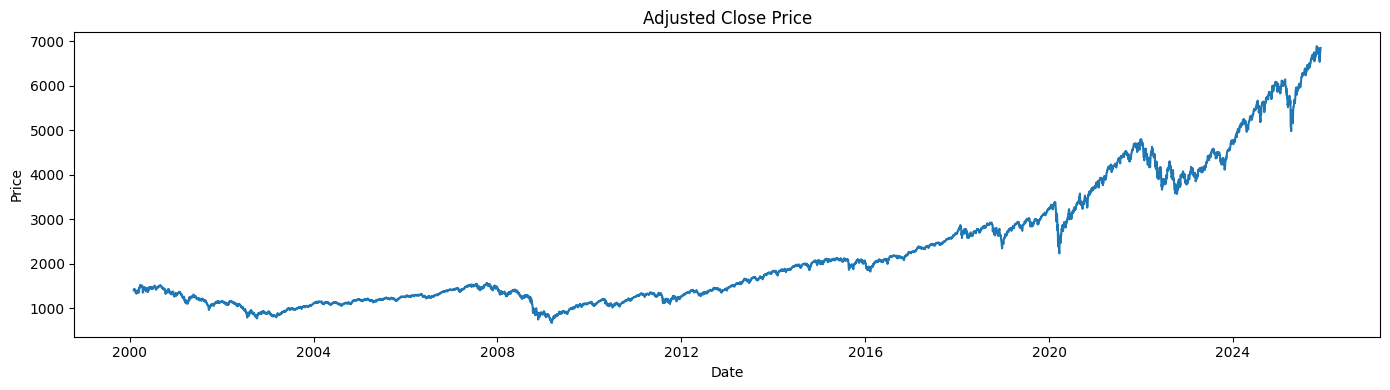

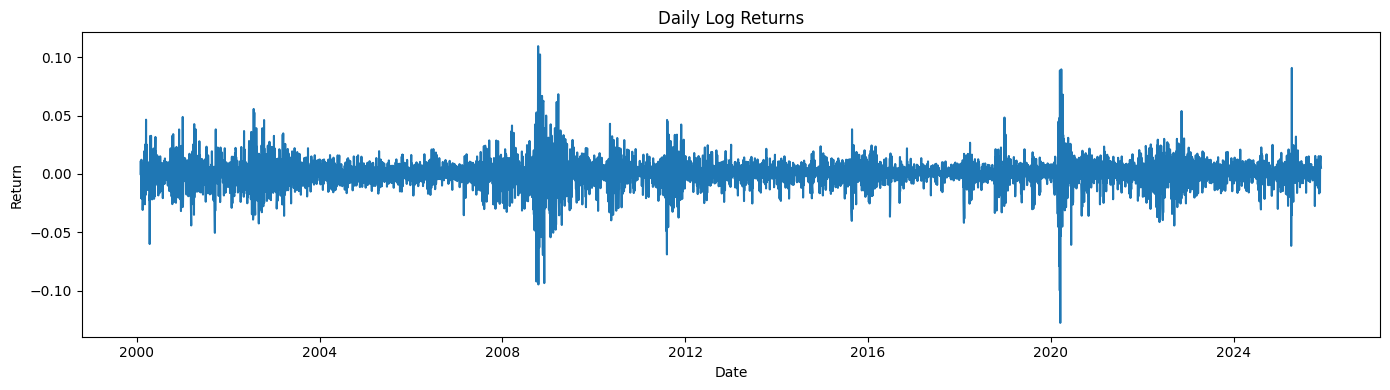

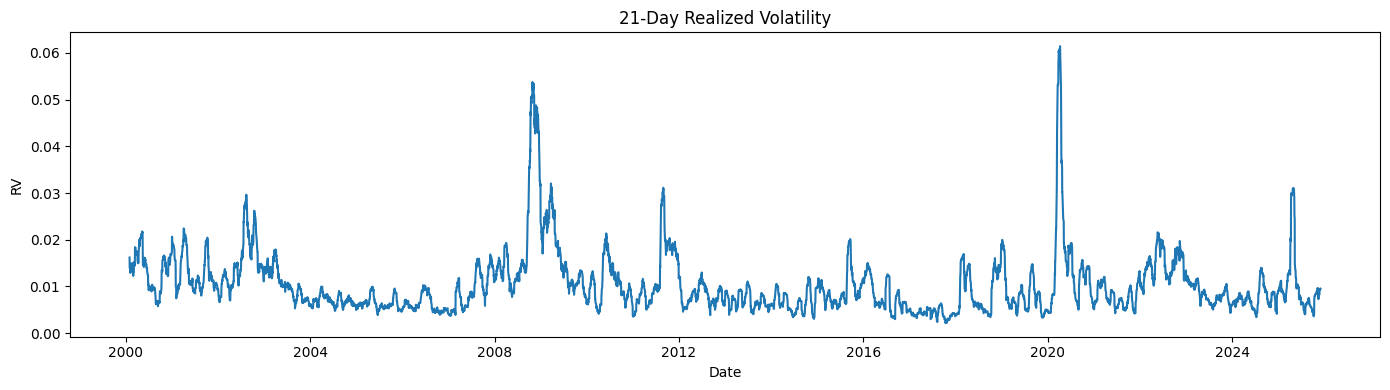

In [12]:
plt.figure(figsize=(14,4))
plt.plot(prices["Date"], prices["Adj Close"])
plt.title("Adjusted Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,4))
plt.plot(prices["Date"], prices["log_return"])
plt.title("Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,4))
plt.plot(prices["Date"], prices["rv_21"])
plt.title("21-Day Realized Volatility")
plt.xlabel("Date")
plt.ylabel("RV")
plt.tight_layout()
plt.show()


## Save the processed dataset

The cleaned final dataset includes:
- Date
- Price series
- Log returns
- Realized volatility (RV_21)

In [13]:
output_path = PROCESSED_DIR / "modeling_dataset.csv"
prices.to_csv(output_path, index=False)

print(f"Saved processed dataset to: {output_path}")


Saved processed dataset to: ..\data\processed\modeling_dataset.csv
